<a href="https://colab.research.google.com/github/ManFat84/Git_Security/blob/main/privacy_preserving_logistic_regressoion_over_RBE_(breast_cancer).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **`Define the utils encryption functions`**

In [ ]:
import random
from typing import List, Tuple


def is_prime(n: int) -> bool:
    """
    Checks if n is prime using trial division
    (sufficient for small P in toy schemes).
    """
    if n <= 1:
        return False
    if n <= 3:
        return True
    if n % 2 == 0 or n % 3 == 0:
        return False
    i = 5
    while i * i <= n:
        if n % i == 0 or n % (i + 2) == 0:
            return False
        i += 6

    return True


def prime_factors(n: int) -> set:
    """
    Returns the set of prime factors of n.
    """
    factors = set()
    i = 2
    while i * i <= n:
        if n % i:
            i += 1
        else:
            n //= i
            factors.add(i)
    if n > 1:
        factors.add(n)

    return factors


def is_generator(g: int, p: int) -> bool:
    """
    Checks if g is a generator of the group Z_p* (multiplicative group modulo p).

    Args:
        g (int): Candidate generator.
        p (int): Prime number (modulus of the group).

    Returns:
        bool: True if g is a generator, False otherwise.
    """
    if not is_prime(p):
        raise ValueError("p must be prime to check for generator.")

    # Group order is p - 1 for Z_p*
    group_order = p - 1

    # Factor the group order (we know p is prime, so we check prime divisors)
    factors = prime_factors(group_order)

    # g is a generator if g^(group_order / q) mod p != 1 for all q in factors
    for factor in factors:
        if pow(g, group_order // factor, p) == 1:
            return False

    return True


def extended_gcd(a: int, b: int) -> Tuple[int, int, int]:
    """
    Computes the greatest common divisor (GCD) of two integers a and b,
    along with the coefficients x and y such that: a*x + b*y = gcd(a, b).
    This is known as the Extended Euclidean Algorithm.

    Args:
        a (int): First integer.
        b (int): Second integer.

    Returns:
        Tuple[int, int, int]: A tuple containing (gcd, x, y) where
        gcd is the greatest common divisor of a and b,
        x and y are the coefficients satisfying Bézout's identity.

    Example:
        >>> extended_gcd(30, 20)
        (10, 1, -1)
        # 30*1 + 20*(-1) = 10
    """
    if a == 0:
        return b, 0, 1

    gcd, x1, y1 = extended_gcd(b % a, a)
    x = y1 - (b // a) * x1
    y = x1

    return gcd, x, y


def modular_inverse(a: int, m: int) -> int:
    """
    Computes the modular inverse of a under modulus m,
    i.e., x such that (a * x) % m == 1.

    It uses the Extended Euclidean Algorithm.

    Args:
        a (int): The number to find the modular inverse of.
        m (int): The modulus.

    Returns:
        int: The modular inverse of a mod m if it exists, else None if the inverse does not exist.
    """
    # Calculate gcd and the coefficients using the extended Euclidean algorithm
    gcd, x, y = extended_gcd(a, m)

    # Modular inverse exists only if gcd is 1
    if gcd != 1:
        raise ValueError(f"No modular inverse for {a} mod {m}")
    else:
        # x might be negative, so we take x % m to get the positive value
        return x % m


def select_random_generator(p: int) -> int:
    if not is_prime(p):
        raise ValueError("p must be prime to select generator.")

    while True:
        g = random.randint(2, p - 2)
        if is_generator(g, p):
            return g


def generate_modular_set(l: int, p: int, target_sum: int) -> List[int]:
    """
    Generates a list of length l of random values modulo P
    such that their sum modulo p equals target_sum.

    Args:
        target_sum (int): The target sum modulo p.

    Returns:
        List[int]: List of integers of length self.l satisfying the sum condition.
    """
    # Create a list of random values mod p
    values = [random.randint(0, p - 1) for _ in range(l - 1)]

    # Calculate the sum of the current values modulo p
    current_sum_mod_p = sum(values) % p

    # Calculate the last value needed to satisfy the condition
    last_value = (target_sum - current_sum_mod_p) % p

    # Append the last value to the set
    values.append(last_value)

    return values


def modular_multiply_sets(
    set1: List[int], set2: List[int], reg: int, p: int, scale: int = None
) -> List[int]:
    """
    Performs modular p multiplication of two sets and adjust values based on k^n.
    n being the highest exponent in the set (set1 and set2 are of size n).

    Args:
        set1 (list): The first set of values of the form [k, k^2, ..., k^l].
        set2 (list): The second set of values of the form [k, k^2, ..., k^l].
        reg (init): Regulator value.
        p (int): The modulus for the modular multiplication.
        scale (int): The scale to use in case of encrypting plaintexts.

    Returns:
        List[int]: A new set after modular multiplication and adjustment.
    """
    assert len(set2) == len(set2)

    l = len(set1)
    result = [0] * l
    for i in range(l):
        for j in range(l):
            # Perform element-wise multiplication modulo p
            element = (set1[i] * set2[j]) % p

            pos = 0
            # Check if the set length is reached
            if i + j >= l - 1:
                # Adjust the value by multiplying it by reg
                element = (element * reg) % p
                pos = i + j - l + 1
            else:
                pos = i + j + 1

            # Insert the value into the result set in the right position
            result[pos] = (result[pos] + element) % p

    # Case when dealing with floats
    if scale:
        result = [(modular_inverse(scale, p) * x) % p for x in result]

    return result


def encode_real(x: float, scale: int) -> tuple[int, float]:
    """Scales a real number to an integer for encryption."""
    return int(round(x * scale)), scale


def decode_real(x_int: int, scale: int, P: int = None) -> float:
    """Scales back integer to real after decryption. Handles centered lifting if P is provided."""
    if P is not None and x_int > P // 2:
        x_int -= P

    return x_int / scale

# **Define the interfaces of the basic RBE**

In [ ]:
from __future__ import annotations
from abc import ABC, abstractmethod
from typing import Any, List, Dict

Ciphertext = List
Plaintext = int


class HomomorphicScheme(ABC):
    """Abstract interface every homomorphic scheme should implement."""

    def __init__(self, *args, **kwargs):
        super().__init__()

    @abstractmethod
    def keygen(self):
        """Generate all necessary keys and parameters (private key, public key, etc.)."""
        pass

    @abstractmethod
    def encrypt(self, m: Plaintext) -> Ciphertext:
        """Encrypt a message m and return ciphertext."""
        ...
        pass

    @abstractmethod
    def decrypt(self, c: Ciphertext) -> Plaintext:
        """Decrypt ciphertext and return plaintext."""
        ...
        pass

    @abstractmethod
    def add(self, c1: Ciphertext, c2: Ciphertext) -> Ciphertext:
        """Homomorphic addition of two ciphertexts."""
        ...
        pass

    @abstractmethod
    def multiply(self, c1: Ciphertext, c2: Ciphertext) -> Ciphertext:
        """Homomorphic multiplication of two ciphertexts."""
        ...
        pass

# **The encryption scheme**

In [ ]:
import random
from typing import List


class ToyFHEncryptor(HomomorphicScheme):
    def __init__(self, P: int, l: int, scale: int, *args, **kwargs) -> None:
        """
        Initialize with small modulus P and parameter l.

        Args:
            P (int): Modulus (prime number recommended for toy use).
            l (int): Length of modular set used in the scheme.
            scale (int): Scale to convert floats to integers.
        """
        super().__init__(*args, **kwargs)

        if not is_prime(P):
            raise ValueError(f"P must be prime, got {P}.")

        self.P = P  # Modulus (prime)
        self.l = l  # Length of sets
        self.scale = scale
        self.k = None  # Base value for the set [k, k^2, ..., k^l]
        self.private_key = None
        self.public_key = None
        self.encrypted_one = None

    def __repr__(self):
        return f"<ToyFHEncryptor P={self.P} l={self.l}>"

    def keygen(self) -> None:
        """
        Generates:
          - private key: random modular set
          - generator g: valid generator mod P
          - public key: g^x mod P for each private key element x
        """
        self.k = select_random_generator(self.P)
        self.reg = modular_inverse(pow(self.k, self.l, self.P), self.P)
        self.private_key = self.generate_private_key()
        self.public_key = self.generate_public_key()
        self.encrypted_one = self.get_encrypted_one()

    def generate_private_key(self) -> List[int]:
        """
        Generates a private key as a list of powers of k modulo P:
        [k^1 mod P, k^2 mod P, ..., k^l mod P]

        Returns:
            List[int]: A list containing [k, k^2, k^3, ..., k^l] with each value taken modulo P.
        """
        return [pow(self.k, i, self.P) for i in range(1, self.l + 1)]

    def generate_public_key(self) -> List[int]:
        """
        Generates a public key using the private key and a modular set summing to 1 mod P.

        Formula:
            >>> public_key[i] = (private_key[i] * ones[i]) mod P
            where 'ones' is a random modular set of length l summing to 1 mod P.
        """
        # Generate modular set summing to 1 mod P, i.e. e(1)
        ones = generate_modular_set(self.l, self.P, 1)
        return [(self.private_key[i] * ones[i]) % self.P for i in range(self.l)]

    def get_encrypted_one(self) -> List[int]:
        """
        Calculates a set of encrypted one suing a trapdoor
        """
        encrypted_one = modular_multiply_sets(
            self.public_key, self.public_key, self.reg, self.P
        )

        # Selecting a trapdoor x for randomness increase, i.e. e(1)^x
        #x = random.randint(0, (self.P - 1)//self.scale)
        x = random.randint(0, 1000)
        for _ in range(x):
            encrypted_one = modular_multiply_sets(
                self.public_key, encrypted_one, self.reg, self.P
            )

        return encrypted_one

    def encrypt(self, m: int | float) -> List[int]:
        """
        Encrypts a plaintext integer into a ciphertext.

        Returns:
            List[int]: list of length l
        """
        if self.public_key is None:
            raise ValueError("Public key not generated yet.")

        m, _ = encode_real(m, self.scale)
        m_set = generate_modular_set(self.l, self.P, m)
        c = [
            sum(self.encrypted_one[i] * m_set[j] for j in range(self.l)) % self.P
            for i in range(self.l)
        ]

        return c

    def decrypt(self, c: List[int]) -> list:
        """
        Decrypt a ciphertext into a plaintext.

        Returns:
            int: plaintext result (sum of decrypted set)
        """
        if self.private_key is None:
            raise ValueError("Private key not generated yet.")

        tmp = [0] * self.l
        m = 0
        for i in range(self.l):
            inv = modular_inverse(pow(self.k, i + 1, self.P), self.P)
            tmp[i] = (inv * c[i]) % self.P
            m = (m + tmp[i]) % self.P

        m = decode_real(m, self.scale, self.P)

        return m

    def add(self, c1: List[int], c2: List[int]) -> List[int]:
        """
        Performs addition of two ciphertexts.
        """
        return [(c1[i] + c2[i]) % self.P for i in range(self.l)]

    def multiply(self, c1: List[int], c2: List[int]) -> List[int]:
        """
        Performs multiplication of two ciphertexts.
        """
        return modular_multiply_sets(c1, c2, self.reg, self.P, self.scale)

# **Demo of HE**

In [ ]:
print("=== Simple Homomorphic Encryption Console Demo ===")

P = 28871271685163 #87803 #
l = 2
scale = 1000000

toyfhe = ToyFHEncryptor(P, l, scale)
toyfhe.keygen()
print(toyfhe)
print(f"Trapdoor k: {toyfhe.k}")
print(f"Private Key: {toyfhe.private_key}")
print(f"Public Key: {toyfhe.public_key}")

m1 = -212
m2 = 12

# Encryption
c1 = toyfhe.encrypt(m1)
c2 = toyfhe.encrypt(m2)
print(f"Encryption1: enc({m1}) = {c1}")
print(f"Encryption2: enc({m2}) = {c2}")

# Decryption
dec1 = toyfhe.decrypt(c1)
dec2 = toyfhe.decrypt(c2)
print(f"Decryption1: dec({c1}) = {dec1}")
print(f"Decryption2: dec({c2}) = {dec2}")

# Homomorphic addition
homomorphic_sum = toyfhe.add(c1, c2)
decrypted_sum = toyfhe.decrypt(homomorphic_sum)
print(
    f"Decrypted Sum: dec({c1} + {c2}) = {decrypted_sum} (Should be {m1} + {m2} = {m1 + m2})"
)

# Homomorphic multiplication
homomorphic_product = toyfhe.multiply(c1, c2)
decrypted_product = toyfhe.decrypt(homomorphic_product)
print(
    f"Decrypted Product: dec({c1} x {c2}) = {decrypted_product} (Should be {m1} * {m2} = {m1 * m2})"
)

=== Simple Homomorphic Encryption Console Demo ===
<ToyFHEncryptor P=28871271685163 l=2>
Trapdoor k: 19339257401013
Private Key: [19339257401013, 12168565881880]
Public Key: [2171639439736, 9113399334685]
Encryption1: enc(-212) = [25949351809329, 1326761972157]
Encryption2: enc(12) = [6702283393386, 4282828067261]
Decryption1: dec([25949351809329, 1326761972157]) = -212.0
Decryption2: dec([6702283393386, 4282828067261]) = 12.0
Decrypted Sum: dec([25949351809329, 1326761972157] + [6702283393386, 4282828067261]) = -200.0 (Should be -212 + 12 = -200)
Decrypted Product: dec([25949351809329, 1326761972157] x [6702283393386, 4282828067261]) = -2544.0 (Should be -212 * 12 = -2544)


# **Load the dataset**

In [ ]:
import numpy as np
import pandas as pd

# loading the data
from google.colab import drive
#drive.mount('/content/drive') # Corrected mountpoint to a directory
data = pd.read_csv('/kaggle/input/breast-cancer-dataset/breast-cancer.csv') # Read the CSV from the mounted directory

# Drop unwanted columns and the column with missing values
# Keep 'diagnosis' as it is the target variable
data = data.drop(columns=["id", "diagnosis", "Unnamed: 32"], errors="ignore")


print(f"Dataset shape: {data.shape}")

FileNotFoundError: [Errno 2] No such file or directory: '/content/data.csv'

# **Data Encryption**

In [ ]:
encrypted_data = []

for i, row in data.iterrows():
    row_enc = row.apply(toyfhe.encrypt)
    encrypted_data.append(row_enc)

df = pd.DataFrame(encrypted_data)
# Save encrypted data in encrypted_data.csv
df.to_csv("encrypted_data.csv", index=False, header=False)

print(f"Dataset shape: {data.shape}")

# Display the first row of the encrypted data
print("First row of the encrypted data:")
display(encrypted_data[0])

# **Data Decryption**

In [ ]:
# loading the data
encrypted_data = pd.read_csv('encrypted_data.csv', header=None)
import ast

for i, row in encrypted_data.iterrows():
  row_lst = row.apply(ast.literal_eval)
  dec = pd.Series([toyfhe.decrypt(x) for x in row_lst])
  print(f"Decryption of row {i}: \n{dec}")
  break

# **Checking**

In [ ]:
# Display the original first row
print("Original first row:")
display(data.iloc[0])

# Display the first decrypted row
print("\nFirst decrypted row:")
display(dec)

# Compare the entire rows
print("\nAre the rows equal?")
display(data.iloc[0].reset_index(drop=True) == dec)

# **Logistic Regression Over Plain Data**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Read the CSV from the mounted directory
data = pd.read_csv('/content/data.csv')

 # Shuffle dataset
data = data.sample(frac=1).reset_index(drop=True)

# Drop the ID column
data = data.drop("id", axis=1)

# Convert target column to binary
data["diagnosis"] = data["diagnosis"].map({"B": 0, "M": 1})

# Split into features (X) and labels (y)
X = data.drop("diagnosis", axis=1)
y = data["diagnosis"]

# Replace inf with nan
X = X.replace([np.inf, -np.inf], np.nan)

# Replace NaN with column means
X = X.apply(lambda col: col.fillna(col.mean()), axis=0)

# Train/test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)


# Feature scaling (Standardization)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit on train, transform train
X_test = scaler.transform(X_test)        # Only transform test
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# Sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Training loop
def train_logistic_regression(X, y, lr=0.01, epochs=500):
    n_samples, n_features = X.shape
    weights = np.random.randn(n_features) * 0.01
    bias = 0.0

    for epoch in range(epochs):
        # Linear combination
        linear_output = np.dot(X, weights) + bias
        # Predictions
        y_pred = sigmoid(linear_output)

        # Gradients
        dw = (1/n_samples) * np.dot(X.T, (y_pred - y))
        db = (1/n_samples) * np.sum(y_pred - y)

        # Update parameters
        weights -= lr * dw
        bias -= lr * db

        # (Optional) track loss
        if epoch % 100 == 0:
            loss = -np.mean(y*np.log(y_pred+1e-8) + (1-y)*np.log(1-y_pred+1e-8))
            print(f"Epoch {epoch}, Loss={loss:.4f}")

    return weights, bias

# Train the model from scratch
weights, bias = train_logistic_regression(X_train, y_train, lr=0.01, epochs=500)

# Predict on test set
y_pred_prob = sigmoid(np.dot(X_test, weights) + bias)
y_pred = (y_pred_prob >= 0.5).astype(int)

# Accuracy
acc = (y_pred == y_test).mean()
print("Logistic Regression (scratch) Accuracy:", acc)



Train shape: (455, 31) Test shape: (114, 31)
Epoch 0, Loss=0.6834
Epoch 100, Loss=0.2473
Epoch 200, Loss=0.1851
Epoch 300, Loss=0.1571
Epoch 400, Loss=0.1406
Logistic Regression (scratch) Accuracy: 0.9736842105263158


# **Logistic Regression Over Cipher Data**

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Dataset prepared with shapes: x_train: torch.Size([455, 30]), y_train: torch.Size([455, 1]), x_test: torch.Size([114, 30]), y_test: torch.Size([114, 1])

Pretraining plaintext model...
[Plain] Epoch 0, Loss: 0.7944
[Plain] Epoch 20, Loss: 0.4912
[Plain] Epoch 40, Loss: 0.3753
Pretraining done in 0.04s
Approximation diagnostics: MAE=0.055345, MAXE=0.110172


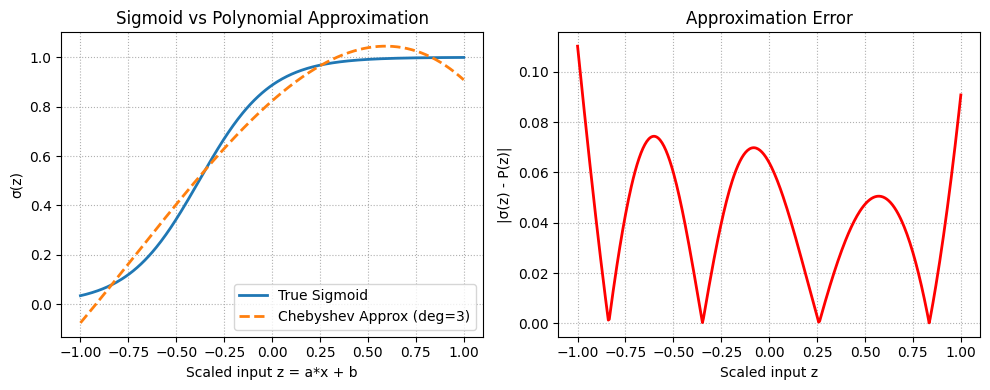


Encrypting dataset...
Dataset encryption done in 0.12s

Starting encrypted training with Chebyshev deg 3 ...
[Enc] Epoch 0 complete
[Enc] Epoch 20 complete
[Enc] Epoch 40 complete
[Enc] Epoch 60 complete
Encrypted training done in 18.84s, accuracy=0.9211

Training plain baseline...
[Plain] Epoch 0, Loss: 1.2555
[Plain] Epoch 20, Loss: 0.6307
[Plain] Epoch 40, Loss: 0.4277
[Plain] Epoch 60, Loss: 0.3408
Plain model accuracy=0.9474, time=0.04s

--- Extended Metrics ---
Encrypted -> MSE: 0.089929, AUC: 0.984015, LogLoss: 0.325854
Plain     -> MSE: 0.077921, AUC: 0.988491, LogLoss: 0.294636

--- Runtime Comparison ---
Plain training time:       0.04s
Encrypted training time:   18.84s
Dataset encryption time:   0.12s
Total encrypted pipeline:  18.96s
Encryption overhead:       18.80s
Slowdown vs plain:         521.3x


In [ ]:
import torch
import pandas as pd
import random
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, roc_auc_score, log_loss
import time
import matplotlib.pyplot as plt
from numpy.polynomial import chebyshev as cheb

# ---------------------------
# Set seeds for reproducibility
# ---------------------------
torch.random.manual_seed(73)
random.seed(73)
np.random.seed(73)

# ---------------------------
# Data loading & preprocessing
# ---------------------------
def breast_cancer_data(path="/content/data.csv"):
    data = pd.read_csv(path)
    data = data.drop(columns=["id", "Unnamed: 32"], errors='ignore')
    data = data.sample(frac=1, random_state=42).reset_index(drop=True)
    data["diagnosis"] = data["diagnosis"].map({"B": 0, "M": 1})

    X = data.drop("diagnosis", axis=1)
    y = data["diagnosis"]

    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.apply(lambda col: col.fillna(col.mean()), axis=0)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    X_train = np.nan_to_num(X_train)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    x_train = torch.tensor(X_train, dtype=torch.float32)
    x_test = torch.tensor(X_test, dtype=torch.float32)
    y_train = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
    y_test = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

    print(
        "Dataset prepared with shapes:",
        f"x_train: {x_train.shape}, y_train: {y_train.shape},",
        f"x_test: {x_test.shape}, y_test: {y_test.shape}"
    )
    return x_train, y_train, x_test, y_test

# ---------------------------
# Plain logistic regression
# ---------------------------
class LR(torch.nn.Module):
    def __init__(self, n_features):
        super(LR, self).__init__()
        self.lr = torch.nn.Linear(n_features, 1)

    def forward(self, x):
        return torch.sigmoid(self.lr(x))

def train(model, optim, criterion, x, y, epochs):
    for epoch in range(epochs):
        optim.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optim.step()
        if epoch % 20 == 0:
            print(f"[Plain] Epoch {epoch}, Loss: {loss.item():.4f}")

def accuracy(model, x, y):
    out = model(x)
    preds = (out > 0.5).float()
    acc = (preds == y).float().mean()
    return acc.item()

# ---------------------------
# Encrypted logistic regression
# ---------------------------
class EncryptedLR:
    def __init__(self, torch_lr, sigmoid_coeffs_power_high_to_low_enc=None, enc_a=None, enc_b=None):
        self.weight = torch_lr.lr.weight.data.tolist()[0]
        self.bias = torch_lr.lr.bias.data.tolist()

        self._delta_w = None
        self._delta_b = None
        self._count = 0
        self.toyfhe = None

        self.sigmoid_coeffs_enc = sigmoid_coeffs_power_high_to_low_enc
        self.enc_a = enc_a
        self.enc_b = enc_b

    def forward(self, enc_x, toyfhe):
        out = toyfhe.encrypt(0)
        for i, w_i in enumerate(self.weight):
            out = toyfhe.add(out, toyfhe.multiply(w_i, enc_x[i]))
        out = toyfhe.add(out, self.bias)
        return out

    def sigmoid(self, enc_logit, toyfhe):
        enc_z = toyfhe.multiply(enc_logit, self.enc_a)
        enc_z = toyfhe.add(enc_z, self.enc_b)
        res = self.sigmoid_coeffs_enc[0]
        for coeff_enc in self.sigmoid_coeffs_enc[1:]:
            res = toyfhe.multiply(res, enc_z)
            res = toyfhe.add(res, coeff_enc)
        return res

    def backward(self, enc_x, enc_out, enc_y, toyfhe):
        neg_one = toyfhe.encrypt(-1)
        enc_neg_y = toyfhe.multiply(enc_y, neg_one)
        enc_diff = toyfhe.add(enc_out, enc_neg_y)
        for i in range(len(enc_x)):
            grad = toyfhe.multiply(enc_x[i], enc_diff)
            self._delta_w[i] = toyfhe.add(self._delta_w[i], grad)
        self._delta_b = toyfhe.add(self._delta_b, enc_diff)
        self._count += 1

    def update_parameters(self, toyfhe, lr=0.005):
        inv_count = -lr / self._count
        enc_factor = toyfhe.encrypt(inv_count)
        for i in range(len(self.weight)):
            update = toyfhe.multiply(self._delta_w[i], enc_factor)
            self.weight[i] = toyfhe.add(self.weight[i], update)
        update_b = toyfhe.multiply(self._delta_b, enc_factor)
        self.bias = toyfhe.add(self.bias, update_b)
        self._delta_w = [toyfhe.encrypt(0) for _ in self.weight]
        self._delta_b = toyfhe.encrypt(0)
        self._count = 0

    def encrypt(self, toyfhe):
        self.toyfhe = toyfhe
        self.weight = [toyfhe.encrypt(w) for w in self.weight]
        self.bias = toyfhe.encrypt(self.bias[0])
        self._delta_w = [toyfhe.encrypt(0) for _ in self.weight]
        self._delta_b = toyfhe.encrypt(0)

    def decrypt(self):
        self.weight = [self.toyfhe.decrypt(w) for w in self.weight]
        self.bias = self.toyfhe.decrypt(self.bias)

    def plain_accuracy(self, x_test, y_test):
        w_tensor = torch.tensor(self.weight, dtype=torch.float32).view(1, -1)
        b_tensor = torch.tensor([self.bias], dtype=torch.float32)
        logits = x_test @ w_tensor.T + b_tensor
        preds = torch.sigmoid(logits)
        preds = (preds > 0.5).float()
        acc = (preds == y_test).float().mean()
        return acc.item()

# ---------------------------
# Main experiment
# ---------------------------
x_train, y_train, x_test, y_test = breast_cancer_data()
n_features = x_train.shape[1]
model = LR(n_features)

# Dummy toy FHE context
P = 28871271685163
l = 2
scale = 1000
toyfhe = ToyFHEncryptor(P, l, scale)
toyfhe.keygen()

# Pretrain plaintext model
plain_model = LR(n_features)
optim = torch.optim.SGD(plain_model.parameters(), lr=0.01)
criterion = torch.nn.BCELoss()
PRETRAIN_EPOCHS = 60
print("\nPretraining plaintext model...")
start_pre = time.time()
train(plain_model, optim, criterion, x_train, y_train, epochs=PRETRAIN_EPOCHS)
print(f"Pretraining done in {time.time() - start_pre:.2f}s")

with torch.no_grad():
    model.lr.weight.data[:] = plain_model.lr.weight.data[:]
    model.lr.bias.data[:] = plain_model.lr.bias.data[:]

# Prepare Chebyshev approximation
with torch.no_grad():
    logits_np = model.lr(x_train).numpy().ravel()
min_val, max_val = float(logits_np.min()), float(logits_np.max())
if max_val == min_val:
    max_val = min_val + 1e-6

margin = 1
a = 2.0 * margin / (max_val - min_val)
b = -margin * (max_val + min_val) / (max_val - min_val)

z_grid = np.linspace(-margin, margin, 400)
x_grid = ((z_grid - b) / a)
y_grid = 1.0 / (1.0 + np.exp(-x_grid))

deg = 3
cheb_poly = cheb.Chebyshev.fit(z_grid, y_grid, deg=deg, domain=[-margin, margin])
poly = cheb_poly.convert(kind=np.polynomial.Polynomial)
coeffs_high_to_low = poly.coef[::-1]

# Diagnostics
logits_scaled = a * logits_np + b
poly_vals = np.polyval(coeffs_high_to_low, logits_scaled)
sig_vals = 1.0 / (1.0 + np.exp(-logits_np))
mae = np.mean(np.abs(poly_vals - sig_vals))
maxe = np.max(np.abs(poly_vals - sig_vals))
print(f"Approximation diagnostics: MAE={mae:.6f}, MAXE={maxe:.6f}")

# --- Plot sigmoid vs polynomial ---
poly_eval = poly(z_grid)
true_eval = 1.0 / (1.0 + np.exp(-((z_grid - b) / a)))
error_vals = np.abs(true_eval - poly_eval)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(z_grid, true_eval, label="True Sigmoid", linewidth=2)
plt.plot(z_grid, poly_eval, "--", label=f"Chebyshev Approx (deg={deg})", linewidth=2)
plt.xlabel("Scaled input z = a*x + b")
plt.ylabel("σ(z)")
plt.title("Sigmoid vs Polynomial Approximation")
plt.legend()
plt.grid(True, linestyle=":")

plt.subplot(1, 2, 2)
plt.plot(z_grid, error_vals, color="red", linewidth=2)
plt.xlabel("Scaled input z")
plt.ylabel("|σ(z) - P(z)|")
plt.title("Approximation Error")
plt.grid(True, linestyle=":")
plt.tight_layout()
plt.show()

# Encrypt coefficients
enc_a = toyfhe.encrypt(a)
enc_b = toyfhe.encrypt(b)
enc_coeffs_high_to_low = [toyfhe.encrypt(float(c)) for c in coeffs_high_to_low]

eelr = EncryptedLR(model, enc_coeffs_high_to_low, enc_a, enc_b)
eelr.encrypt(toyfhe)

# ---------------------------
# Encrypt dataset
# ---------------------------
print("\nEncrypting dataset...")
start_encrypt = time.time()
enc_X = [[toyfhe.encrypt(xi) for xi in x.tolist()] for x in x_train]
enc_y = [toyfhe.encrypt(yi.item()) for yi in y_train]
enc_dataset_time = time.time() - start_encrypt
print(f"Dataset encryption done in {enc_dataset_time:.2f}s")

# ---------------------------
# Encrypted training
# ---------------------------
EPOCHS = 80
print(f"\nStarting encrypted training with Chebyshev deg {deg} ...")
start_enc_train = time.time()
for epoch in range(EPOCHS):
    for enc_x, enc_yi in zip(enc_X, enc_y):
        enc_out = eelr.forward(enc_x, toyfhe)
        enc_out = eelr.sigmoid(enc_out, toyfhe)
        eelr.backward(enc_x, enc_out, enc_yi, toyfhe)
    eelr.update_parameters(toyfhe, lr=0.01)
    if epoch % 20 == 0:
        print(f"[Enc] Epoch {epoch} complete")
enc_time = time.time() - start_enc_train
eelr.decrypt()
enc_acc = eelr.plain_accuracy(x_test, y_test)
print(f"Encrypted training done in {enc_time:.2f}s, accuracy={enc_acc:.4f}")

# ---------------------------
# Plain baseline
# ---------------------------
final_plain_model = LR(n_features)
optim = torch.optim.SGD(final_plain_model.parameters(), lr=0.01)
criterion = torch.nn.BCELoss()
print("\nTraining plain baseline...")
start_plain = time.time()
train(final_plain_model, optim, criterion, x_train, y_train, epochs=EPOCHS)
plain_time = time.time() - start_plain
plain_acc = accuracy(final_plain_model, x_test, y_test)
print(f"Plain model accuracy={plain_acc:.4f}, time={plain_time:.2f}s")

# ---------------------------
# Extended metrics
# ---------------------------
with torch.no_grad():
    w_e = torch.tensor(eelr.weight, dtype=torch.float32).view(1, -1)
    b_e = torch.tensor([eelr.bias], dtype=torch.float32)
    probs_e = torch.sigmoid(x_test @ w_e.T + b_e).numpy().ravel()
    probs_p = final_plain_model(x_test).numpy().ravel()
    y_true = y_test.numpy().ravel()

mse_enc = mean_squared_error(y_true, probs_e)
auc_enc = roc_auc_score(y_true, probs_e)
loss_enc = log_loss(y_true, probs_e)

mse_plain = mean_squared_error(y_true, probs_p)
auc_plain = roc_auc_score(y_true, probs_p)
loss_plain = log_loss(y_true, probs_p)

print("\n--- Extended Metrics ---")
print(f"Encrypted -> MSE: {mse_enc:.6f}, AUC: {auc_enc:.6f}, LogLoss: {loss_enc:.6f}")
print(f"Plain     -> MSE: {mse_plain:.6f}, AUC: {auc_plain:.6f}, LogLoss: {loss_plain:.6f}")

# ---------------------------
# Runtime and Encryption Comparison
# ---------------------------
encryption_overhead = enc_time - plain_time
total_enc_pipeline = enc_dataset_time + enc_time
slowdown_ratio = total_enc_pipeline / max(plain_time, 1e-9)

print("\n--- Runtime Comparison ---")
print(f"Plain training time:       {plain_time:.2f}s")
print(f"Encrypted training time:   {enc_time:.2f}s")
print(f"Dataset encryption time:   {enc_dataset_time:.2f}s")
print(f"Total encrypted pipeline:  {total_enc_pipeline:.2f}s")
print(f"Encryption overhead:       {encryption_overhead:.2f}s")
print(f"Slowdown vs plain:         {slowdown_ratio:.1f}x")


In [1]:
!git config --global user.name "https://github.com/ManFat84"
!git config --global user.email "mansour.fat84@gmail.com"


In [2]:
!git clone https://github.com/ManFat84/PPLR_over_RBE.git
%cd your-repo


Cloning into 'PPLR_over_RBE'...
fatal: could not read Username for 'https://github.com': No such device or address
[Errno 2] No such file or directory: 'your-repo'
/content


In [3]:
!git clone https://github.com/ManFat84/PPLR_over_RBE.git
%cd PPLR_over_RBE


Cloning into 'PPLR_over_RBE'...
fatal: could not read Username for 'https://github.com': No such device or address
[Errno 2] No such file or directory: 'PPLR_over_RBE'
/content
